In [1]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

In [2]:
url_matches = "https://raw.githubusercontent.com/Blaieet/Vis.-Presentation-Project/main/DistsAndTeamPerfVsPlayerRating/match_clean_player_4.csv?token=ARH4TB6KNOUIDCHZK3TF2MK7YYLUE"
url_players = "https://raw.githubusercontent.com/Blaieet/Vis.-Presentation-Project/main/DistsAndTeamPerfVsPlayerRating/player_att_clean.csv?token=ARH4TB4O7DTAONQMCD4PVH27YYMAS"
url_teams = "https://raw.githubusercontent.com/Blaieet/Vis.-Presentation-Project/main/DistsAndTeamPerfVsPlayerRating/team_att_clean.csv?token=ARH4TB4LTCYTR732ORM7JKC7YYMBS"
url_teamnames = "https://raw.githubusercontent.com/Blaieet/Vis.-Presentation-Project/main/DistsAndTeamPerfVsPlayerRating/team.csv?token=ARH4TB5ZIRANWBMV5K35E5C7YY47A"

match_clean_player_4 = pd.read_csv(url_matches)
player_att_clean = pd.read_csv(url_players)
team_att_clean = pd.read_csv(url_teams)
team_clean = pd.read_csv(url_teamnames)
#team_clean.head()

HTTPError: HTTP Error 404: Not Found

In [ ]:
team_clean

In [ ]:
# Attributing a shorter and easiest variable name to Exploratory Data Analysis
df = match_clean_player_4.copy()
print(df.shape)
df.head(5)

### Preliminar plot

The idea at first was to see if there was a positive correlation between team performance (measured in number of points earned per game: 3 if the team won, 1 if there was a draw and 0 if they lost) and mean player quality of the team (measured by their overall rating, included in the FIFA videogame attributes). Since both team perdormance and player rating are time-dependent, one would in principle have to consider a finite period of time (say, a season) for any meaningful pattern to show up.

So we set to get the said quantities for a given season. For that, one needs to go to the cleaned matches table and retrieve the points earned by each team at each match and the player id's of each ...

Fracton of missing players for this season and league 0.09206678266020064


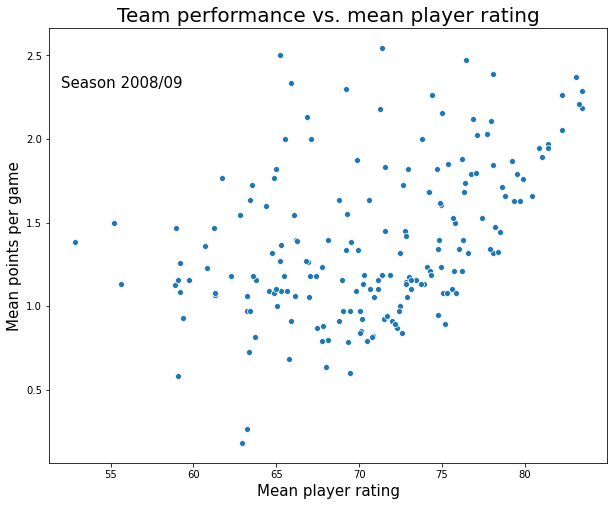

In [57]:
import seaborn as sns

playatts_alltime = player_att_clean.groupby(by=["player_api_id"]).mean()
genfont = 15
titfont = 20

seasons = np.unique(df["season"])

season_matches = df[df["season"] == seasons[0]]
#season_matches = season_matches[season_matches["league"] == "LIGA BBVA"]
start_date = "2008-09-01"; end_date = "2009-09-01"

team_points = season_matches.groupby(by=["match_api_id","team_api_id"]).mean()
team_points = team_points.groupby(by=["team_api_id"]).mean()

playatts_season = player_att_clean[player_att_clean["date"]>start_date]
playatts_season = playatts_season[playatts_season["date"]<end_date]
playatts_season = playatts_season.groupby(by=["player_api_id"]).mean()

pts_vs_rating = []
matches = np.unique(season_matches["match_api_id"])
missing_players_season = 0; total_players_season = 0

for match in matches:
    match_df = season_matches[season_matches["match_api_id"] == match]
    #print(match)
    teams = np.unique(match_df["team_api_id"])
    #print(teams)
    for team in teams:
        team_df = match_df[match_df["team_api_id"] == team]
        mean_team_rating = 0; count = 0
        for player in np.unique(team_df["player_api_id"]):
            total_players_season += 1
            try:
                mean_team_rating += playatts_season["overall_rating"][player]
                count += 1
                #print("player found!")
            except:
                try:
                    mean_team_rating += playatts_alltime["overall_rating"][player]
                    count += 1
                    #print ("player found only in all time table")
                except:
                    missing_players_season += 1
                    #print("player not found in player_att_clean")
        # there are some teams for which none of the players can be found
        if count != 0:
            mean_team_rating = mean_team_rating/count
            team_name = team_clean[team_clean["team_api_id"]==team]["team_long_name"].values[0]
            point = [team, team_name, mean_team_rating, team_points["points"][team]]
            pts_vs_rating.append(point)
print("Fracton of missing players for this season and league", 
      missing_players_season/total_players_season)
#pts_vs_rating

#PLOTTING
points_vs_rating = pd.DataFrame(pts_vs_rating, columns=["team_api_id", "team_name", "mean_player_rating",
                                                       "points_per_game"])
# average over team duplicates
points_vs_rating = points_vs_rating.groupby(by="team_name").mean()
points_vs_rating.reset_index(inplace=True)

plt.figure(figsize = (10,8))
p1 = sns.scatterplot(data=points_vs_rating, x="mean_player_rating", y="points_per_game",
                palette="BuGn")
#p2 = sns.scatterplot(data=points_vs_rating.iloc[:15,:], x="mean_player_rating", y="points_per_game",
 #               palette="BuGn", color="red", size=1000*np.ones((15)))
plt.xlabel("Mean player rating", fontsize=genfont)
plt.ylabel("Mean points per game", fontsize=genfont)
plt.title("Team performance vs. mean player rating", fontsize=titfont)
p1.text(52,2.2, "Season 2008/09\n", fontsize=genfont)

plt.show()
            

Nice! Let us try implementing the plot in Altair. We also tried a regression line to make the tendency more apparent, but it doesn't seem to work while using interactive().

In [58]:
points = alt.Chart(points_vs_rating).mark_circle(size=80,opacity=0.8, 
                                         color='green').encode(alt.X('mean_player_rating',
                                          scale=alt.Scale(zero=False),
                                          axis=alt.Axis(title='Team mean player rating')), 
                                          alt.Y('points_per_game',
                                          scale=alt.Scale(zero=False), axis=alt.Axis(title='Points per game')),
                                          #color="team_name", 
                                          tooltip="team_name").interactive().properties(
                                              title="All leagues, season 2008/2009")

# for some reason, regression doesn't work with interaction
display(points #+ points.transform_regression("mean_player_rating","points_per_game").mark_line()
)

print("Awesome!")


alt.Chart(...)

Awesome!


### Serious plots

The tables for every season and league are stored in
"data/"+str(season[:4])+"-"+"".join(league.split())+".csv" ,
where "season[:4]" is the first year of the season ("2008" for 2008/2009) and "league" is one of the leagues listed below.

In [59]:
np.unique(df["league"])

array(['1. Bundesliga', 'Ekstraklasa', 'Eredivisie', 'Jupiler League',
       'LIGA BBVA', 'Liga ZON Sagres', 'Ligue 1', 'Premier League',
       'Scottish Premiership', 'Serie A', 'Super League'], dtype=object)

In [60]:
df.head()

,country_id,country,league,season,stage,date,match_year,match_api_id,team_flag,team_api_id,team_long_name,team_short_name,team_goals,result,points,player_api_id,player_name,birthday,height,weight
0,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,30823,Stephane Grichting,1979-03-30,185.42,176
1,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,30977,Dariusz Dudka,1983-12-09,182.88,185
2,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,34037,Ireneusz Jelen,1981-04-09,182.88,163
3,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,40714,Remy Riou,1987-08-06,187.96,179
4,4769,France,Ligue 1,2008/2009,1,2008-08-09,2008,483129,home_team,8583,AJ Auxerre,AUX,2,won,3,11323,Cedric Hengbart,1980-07-13,182.88,161


In [61]:
points_vs_rating.columns

Index(['team_name', 'team_api_id', 'mean_player_rating', 'points_per_game'], dtype='object')

In [62]:
points_vs_rating.head()

,team_name,team_api_id,mean_player_rating,points_per_game
0,1. FC Köln,8722.0,72.824495,1.147059
1,AC Bellinzona,6493.0,58.929815,1.466667
2,ADO Den Haag,10217.0,64.534704,1.090909
3,AJ Auxerre,8583.0,71.562418,1.447368
4,AS Monaco,9829.0,71.404209,1.184211


In [111]:
points_vs_rating.to_csv("points_vs_ratingNormal.csv")

In [112]:
start_date = "2010-09-01"
end_date = "2011-09-01"


playatts_alltime = player_att_clean.groupby(by=["player_api_id"]).mean()

season_matches = df[df["season"] == "2010/2011"]
league_matches = season_matches[season_matches["league"] == "LIGA BBVA"]
team_points = league_matches.groupby(by=["match_api_id", "team_api_id"]).mean()
team_points = team_points.groupby(by=["team_api_id"]).mean()

playatts_season = player_att_clean[player_att_clean["date"] > start_date]
playatts_season = playatts_season[playatts_season["date"] < end_date]
playatts_season = playatts_season.groupby(by=["player_api_id"]).mean()

pts_vs_rating = []
matches = np.unique(league_matches["match_api_id"])
for match in matches:
    match_df = league_matches[league_matches["match_api_id"] == match]
    teams = np.unique(match_df["team_api_id"])
    for team in teams:
        team_df = match_df[match_df["team_api_id"] == team]
        mean_team_rating = 0
        count = 0
        for player in np.unique(team_df["player_api_id"]):
            try:
                mean_team_rating += playatts_season["overall_rating"][player]
                count += 1
                # print("player found!")
            except:
                try:
                    mean_team_rating += playatts_alltime["overall_rating"][player]
                    count += 1
                    # print ("player found only in all time table")
                except:
                    pass
                    # print("player not found in player_att_clean")
        # there are some teams for which none of the players can be found
        if count > 0:
            mean_team_rating = mean_team_rating / count
            team_name = team_clean[team_clean["team_api_id"] == team]["team_long_name"].values[0]
            point = [team, team_name, mean_team_rating, team_points["points"][team]]
            pts_vs_rating.append(point)
# pts_vs_rating

points_vs_rating = pd.DataFrame(pts_vs_rating, columns=["team_api_id", "team_name",
                                                        "mean_player_rating",
                                                        "points_per_game"])
# average over team duplicates
points_vs_rating = points_vs_rating.groupby(by="team_name").mean()
points_vs_rating.reset_index(inplace=True)

points = alt.Chart(points_vs_rating).mark_circle(size=80, opacity=0.8,
                                                 color='green').encode(alt.X('mean_player_rating',
                                                                             scale=alt.Scale(zero=False),
                                                                             axis=alt.Axis(
                                                                                 title='Team mean player rating')),
                                                                       alt.Y('points_per_game',
                                                                             scale=alt.Scale(zero=False),
                                                                             axis=alt.Axis(
                                                                                 title='Points per game')),
                                                                       color="team_name:N",
                                                                       tooltip="team_name")

points = points + points.transform_regression("mean_player_rating", "points_per_game").mark_line().transform_fold(["Regression Line"],
                                                                                         as_=["Regression", "a"]).encode(
    color="Regression:N")

chart = points.interactive()
chart

alt.LayerChart(...)

In [35]:
leagues

['1. Bundesliga',
 'Eredivisie',
 'LIGA BBVA',
 'Ligue 1',
 'Premier League',
 'Serie A']

In [85]:
#import seaborn as sns

playatts_alltime = player_att_clean.groupby(by=["player_api_id"]).mean()
genfont = 15
titfont = 20

seasons = np.unique(df["season"])
leagues = ['1. Bundesliga', 'Eredivisie',
       'LIGA BBVA','Ligue 1', 'Premier League','Serie A']
start_date = "2008-09-01"; end_date = "2009-09-01"; addyears = 0
missing_players = []

for season in seasons:
    start_date = str(int(start_date[:4])+addyears)+"-09-01"
    end_date = str(int(end_date[:4])+addyears)+"-09-01"
    print(start_date,end_date)
    addyears += 1
    season_matches = df[df["season"] == season]
    
    for league in leagues:
        league_matches = season_matches[season_matches["league"] == league]
        if league_matches.empty:
            print("No matches for league", league, "in season", season,
                  ". Skipping the league for this season...")
            continue
        team_points = league_matches.groupby(by=["match_api_id","team_api_id"]).mean()
        team_points = team_points.groupby(by=["team_api_id"]).mean()

        playatts_season = player_att_clean[player_att_clean["date"]>start_date]
        playatts_season = playatts_season[playatts_season["date"]<end_date]
        playatts_season = playatts_season.groupby(by=["player_api_id"]).mean()
        #print("playatts empty? ",playatts_season.empty)
        
        pts_vs_rating = []
        matches = np.unique(league_matches["match_api_id"])
        for match in matches:
            match_df = league_matches[league_matches["match_api_id"] == match]
            teams = np.unique(match_df["team_api_id"])
            for team in teams:
                team_df = match_df[match_df["team_api_id"] == team]
                mean_team_rating = 0; count = 0
                for player in np.unique(team_df["player_api_id"]):
                    try:
                        mean_team_rating += playatts_season["overall_rating"][player]
                        count += 1
                        #print("player found!")
                    except:
                        try:
                            mean_team_rating += playatts_alltime["overall_rating"][player]
                            count += 1
                            #print ("player found only in all time table")
                        except:
                            missing_players.append(player)
                            #print("player not found in player_att_clean")
                # there are some teams for which none of the players can be found
                if count > 0:
                    mean_team_rating = mean_team_rating/count
                    team_name = team_clean[team_clean["team_api_id"]==team]["team_long_name"].values[0]
                    point = [team, team_name, mean_team_rating, team_points["points"][team]]
                    pts_vs_rating.append(point)
        #pts_vs_rating

        #define dataframe with resulting table for export and plot
        points_vs_rating = pd.DataFrame(pts_vs_rating, columns=["team_api_id", "team_name",
                                                                "mean_player_rating",
                                                               "points_per_game"])
        
        # average over team duplicates
        points_vs_rating = points_vs_rating.groupby(by="team_name").mean()
        points_vs_rating.reset_index(inplace=True)

        # export tables to csv's
        #points_vs_rating.to_csv("data/"+str(season[:4])+"-"+"".join(league.split())+".csv")
        
        title = "Season "+str(season)+", "+str(league)
        points = alt.Chart(points_vs_rating).mark_circle(size=80,opacity=0.8, 
                                         color='green').encode(alt.X('mean_player_rating',
                                          scale=alt.Scale(zero=False),
                                          axis=alt.Axis(title='Team mean player rating')), 
                                          alt.Y('points_per_game',
                                          scale=alt.Scale(zero=False), axis=alt.Axis(title='Points per game')),
                                          color="team_name", 
                                          tooltip="team_name").properties(
                                              title=title)
        points = points + points.transform_regression("mean_player_rating","points_per_game").transform_fold(
            ["reg-line"], as_=["Regression", "points_per_game"]).encode(alt.Color("Regression:N")).mark_line()
        display(points)

print ("Number of missing players over all seasons and leagues:\n",
       len(np.unique(missing_players)))
print ("Number of all players in player_att_clean:\n",
       len(np.unique(player_att_clean["player_api_id"])))


            

2008-09-01 2009-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2009-09-01 2010-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2011-09-01 2012-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2014-09-01 2015-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2018-09-01 2019-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2023-09-01 2024-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2029-09-01 2030-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

2036-09-01 2037-09-01


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

Number of missing players over all seasons and leagues:
 315
Number of all players in player_att_clean:
 10410


In [28]:
points_vs_rating

,team_name,team_api_id,mean_player_rating,points_per_game
0,Athletic Club de Bilbao,8315,73.459676,1.157895
1,Atlético Madrid,9906,79.889952,1.763158
2,CA Osasuna,8371,72.803575,1.131579
3,CD Numancia,8388,70.197412,0.921053
4,FC Barcelona,8634,83.444754,2.289474
5,Getafe CF,8305,75.598046,1.105263
6,Málaga CF,9864,72.774880,1.447368
7,RC Deportivo de La Coruña,9783,75.663363,1.526316
8,RC Recreativo,8479,72.268049,0.868421
9,RCD Espanyol,8558,74.968122,1.236842


In [30]:
points_vs_rating

,team_name,team_api_id,mean_player_rating,points_per_game
0,Atalanta,8524,70.919412,1.184211
1,Bologna,9857,70.654280,1.105263
2,Carpi,208931,67.346338,1.000000
3,Chievo Verona,8533,72.123559,1.315789
4,Empoli,8534,67.985951,1.210526
5,Fiorentina,8535,74.855862,1.684211
6,Frosinone,9891,65.057623,0.815789
7,Genoa,10233,71.513042,1.210526
8,Hellas Verona,9876,68.935555,0.736842
9,Inter,8636,76.410588,1.763158


In [82]:
import altair as alt
from vega_datasets import data
import pandas as pd

source = data.anscombe().copy()
source['line-label'] = 'x=y'
source = pd.concat([source,source.groupby('Series').agg(x_diff=('X','diff'), y_diff=('Y','diff'))],axis=1)
source['rate'] = source.y_diff/source.x_diff
source['rate-label'] = 'line y=x'

scatter = alt.Chart(source).mark_circle(size=60, opacity=0.60).encode(
    x='X:Q',
    y='Y:Q',
    color='Series:N',
    tooltip=['X','Y','rate']
)

scatter = scatter + scatter.transform_regression('X', 'Y').mark_line(
     opacity=0.50, 
     shape='mark'
).transform_fold(
     ["reg-line"], 
     as_=["Regression", "y"]
).encode(alt.Color("Regression:N"))
chart = scatter.facet(
    columns=2
    , facet=alt.Facet('Series',header=alt.Header(labelFontSize=25))
).resolve_scale(
    x='independent',
    y='independent'
)

chart.display()

alt.FacetChart(...)